# Importing Libraries

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import time
sns.set_style("darkgrid")

* Pandas Options

In [3]:
pd.set_option('max_columns', None)

* Tqdm Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint import

In [5]:
total_df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip') # already non-null litho classes

In [6]:
total_df.head()

,CALI,DEPTH,DTC,GR,NPHI,RDEP,RHOB,RMED,LITHOLOGY_GEOLINK
0,17.298321,1211.427612,162.090195,38.290401,0.433110,1.715750,1.9633,0.971366,NaN
1,17.328560,1211.580078,162.100098,34.937000,0.425595,1.682424,1.9647,1.059951,NaN
2,17.363529,1211.732422,162.109894,36.094898,0.423601,1.649250,1.9665,1.300320,NaN
3,17.647690,1211.884888,162.119797,34.718700,0.419761,1.615834,1.9645,1.262250,NaN
4,18.145281,1212.037231,162.129700,38.474899,0.365538,1.573810,1.9360,1.073449,NaN


* Classes Balance

Text(0.5, 1.0, 'Lithology Classes - Target Variable Balance')

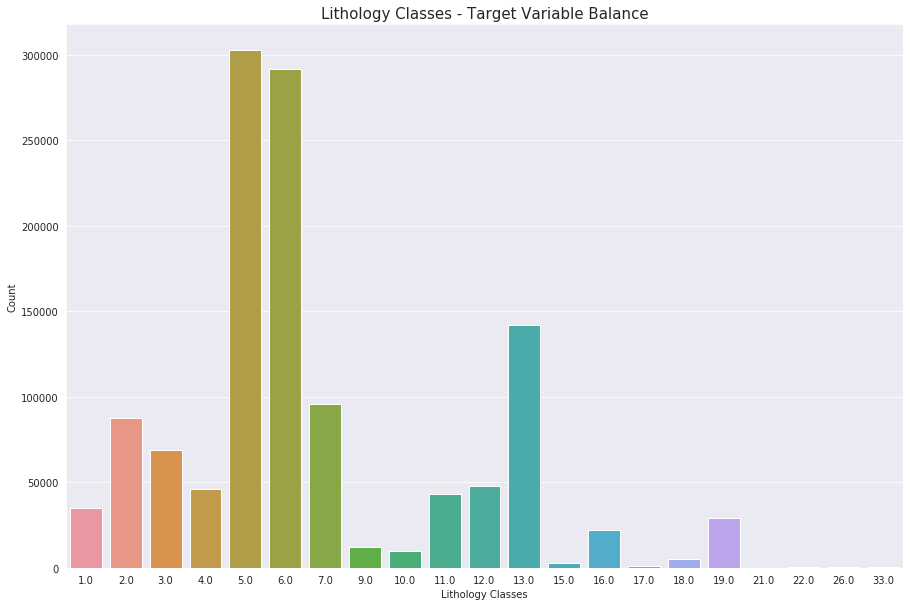

In [7]:
plt.figure(figsize=(15,10))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Lithology Classes - Target Variable Balance', fontsize=15)

* Merging Some Classes for better geological behavior

In [8]:
total_df['LITHOLOGY_GEOLINK_2'] = total_df['LITHOLOGY_GEOLINK']

for code in tqdm_notebook(total_df.index, desc='Regrouping lithologies'):

    if (total_df['LITHOLOGY_GEOLINK_2'][code] == 2 or total_df['LITHOLOGY_GEOLINK_2'][code] == 3):

        total_df['LITHOLOGY_GEOLINK_2'][code] = 1

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 6:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 5

    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 34:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 33


    elif total_df['LITHOLOGY_GEOLINK_2'][code] == 13:

        total_df['LITHOLOGY_GEOLINK_2'][code] = 12

    else:
        
        pass

Text(0.5, 1.0, 'Condensed Lithology Classes - Target Variable Balance')

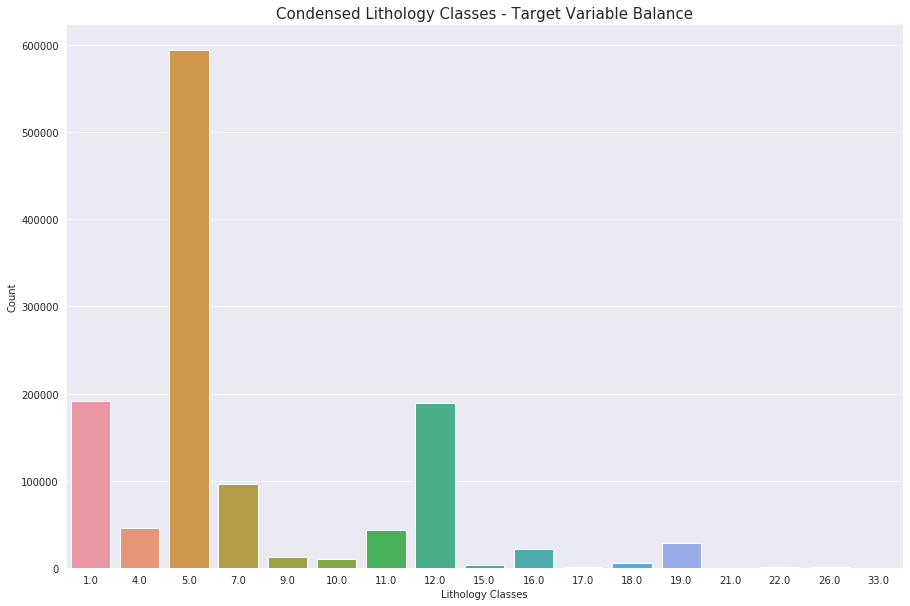

In [9]:
plt.figure(figsize=(15,10))

sns.barplot(x=total_df['LITHOLOGY_GEOLINK_2'].value_counts().index, y=total_df['LITHOLOGY_GEOLINK_2'].value_counts())
plt.xlabel('Lithology Classes', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Condensed Lithology Classes - Target Variable Balance', fontsize=15)

# Feature Engineering

* DRDN

In [10]:
total_df['DRDN'] = ((total_df['RHOB'] - 2)/0.05) - ((0.45 - total_df['NPHI'])/0.03)

Text(0.5, 1.0, 'DRDN distribution -- Mu: 1.2071987005038889 Sigma: 3.8478575072107133')

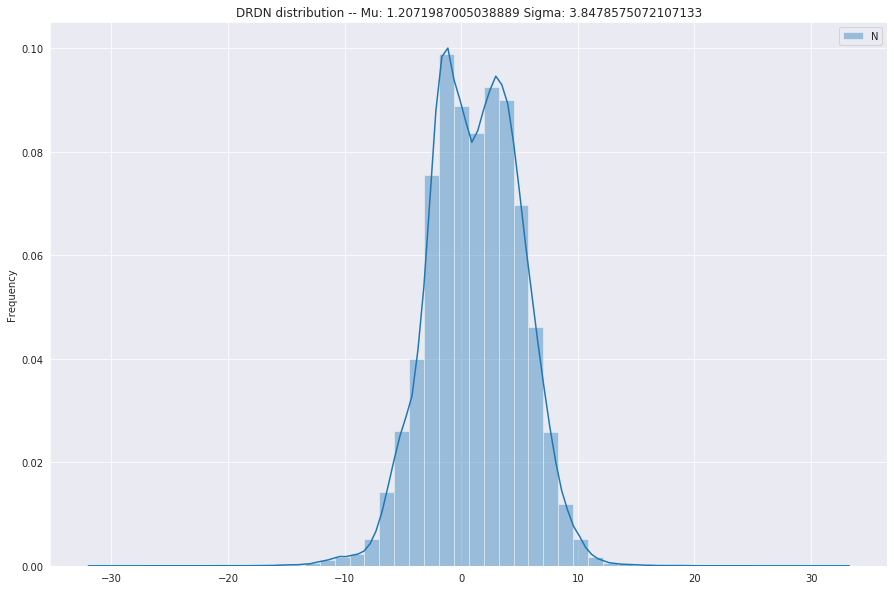

In [11]:
(mu, sigma) = stats.norm.fit(total_df[total_df.DRDN.notnull()].DRDN.values)

plt.figure(figsize=(15,10))

sns.distplot(total_df[total_df.DRDN.notnull()].DRDN.values);

plt.legend('Normal distribution')

plt.ylabel('Frequency')

plt.title('DRDN distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

* Acoustic Impedance

In [12]:
total_df['AI'] = total_df['RHOB'] * (1e6/total_df['DTC']) * 0.3048

Text(0.5, 1.0, 'AI distribution -- Mu: 6676.131418354684 Sigma: 2460.057586026266')

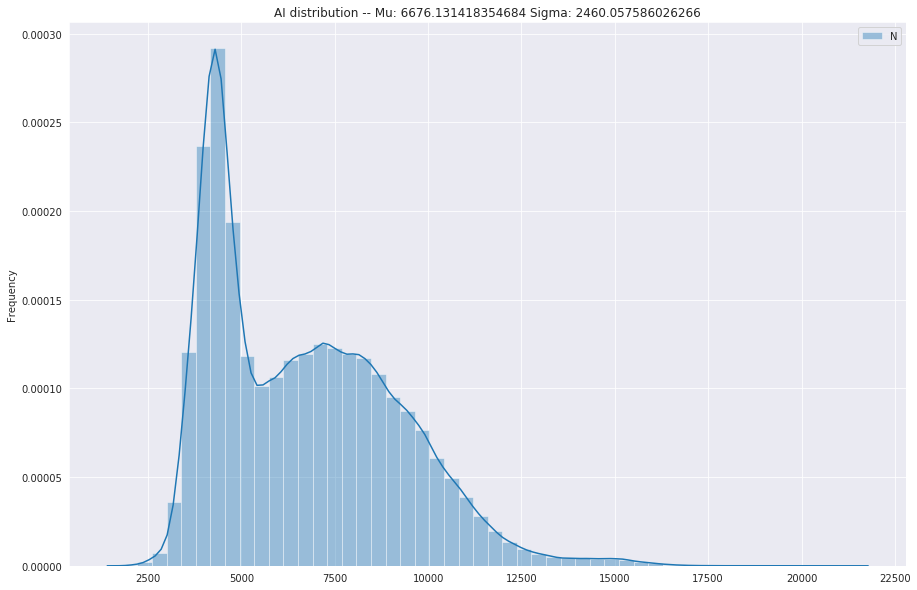

In [13]:
(mu, sigma) = stats.norm.fit(total_df[total_df.AI.notnull()].AI.values)

plt.figure(figsize=(15,10))

sns.distplot(total_df[total_df.AI.notnull()].AI.values);

plt.legend('Normal distribution')

plt.ylabel('Frequency')

plt.title('AI distribution -- Mu:' + ' ' + str(mu) + ' ' + 'Sigma:' + ' ' + str(sigma) )

# Lithology Code Prediction

* LITHOLOGY_GEOLINK non NULL data

In [14]:
litho_data = total_df[pd.notnull(total_df['LITHOLOGY_GEOLINK_2'])].drop(columns=['LITHOLOGY_GEOLINK']) # litho2 optimum set (84.5)

litho_data.head(n=5)

,CALI,DEPTH,DTC,GR,NPHI,RDEP,RHOB,RMED,LITHOLOGY_GEOLINK_2,DRDN,AI
5748,22.227711,2087.422852,106.162109,70.047096,0.229250,0.807055,2.290600,0.739214,5.0,-1.546338,6576.497988
5749,21.889860,2087.575195,106.615601,67.606010,0.241230,0.815097,2.301183,0.755799,5.0,-0.935331,6578.779935
5750,21.816292,2087.727539,106.951202,68.638336,0.233404,0.820424,2.327358,0.775099,5.0,-0.672703,6632.732543
5751,22.000708,2087.880127,106.952103,63.397800,0.238283,0.827512,2.383800,0.791133,5.0,0.618775,6793.529356
5752,22.061703,2088.032471,106.952103,64.541100,0.239512,0.844115,2.422600,0.825076,5.0,1.435743,6904.104464


In [15]:
len(litho_data) # samples to build the ML model

1243234

    * Converting LITHOLOGY_GEOLINK to int type

In [16]:
litho_data['LITHOLOGY_GEOLINK_2'] = litho_data['LITHOLOGY_GEOLINK_2'].astype(int)

* Dataset Creation

In [17]:
from sklearn.model_selection import train_test_split

X = litho_data.drop(columns='LITHOLOGY_GEOLINK_2')

Y = litho_data['LITHOLOGY_GEOLINK_2'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

In [18]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (621617, 10) (621617,)
### Test Dataset: ###  (621617, 10) (621617,)


* Model Selection

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, cross_validate

class_pipelines = []

class_pipelines.append(('ScaledRidge', Pipeline([('Scaler', RobustScaler()),('Ridge', linear_model.RidgeClassifier())])))
class_pipelines.append(('ScaledSGDCls', Pipeline([('Scaler', RobustScaler()),('SGDCls', linear_model.SGDClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledKNNCls', Pipeline([('Scaler', RobustScaler()),('KNNCls', KNeighborsClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledDTC', Pipeline([('Scaler', RobustScaler()),('DTC', DecisionTreeClassifier())])))
class_pipelines.append(('ScaledRFC', Pipeline([('Scaler', RobustScaler()),('RFC', RandomForestClassifier(n_jobs=60))])))
class_pipelines.append(('ScaledXGB', Pipeline([('Scaler', RobustScaler()),('XGB', XGBClassifier(tree_method='gpu_hist', gpu_id=2))])))
class_pipelines.append(('ScaledCAT', Pipeline([('Scaler', RobustScaler()),('CAT', CatBoostClassifier(verbose=False, task_type='GPU', devices='0-2'))])))
class_pipelines.append(('ScaledLGBM', Pipeline([('Scaler', RobustScaler()),('LGBM', LGBMClassifier(n_jobs=60))])))


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, make_scorer

results = []

names = []

for name, model in tqdm_notebook(class_pipelines, desc='Cross-Validation Procedure'):

    kfold = KFold(n_splits=5, random_state=42)

    scorers = {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score), 'f1': make_scorer(f1_score, average='macro')}

    final_scorers = cross_validate(model, x_train, y_train, cv=kfold, scoring=scorers)
    results.append(final_scorers)
    names.append(name)
    print(name, 'Acc: ', final_scorers['test_accuracy'].mean(), '\\', final_scorers['test_accuracy'].std(), '\n')
    print(name, 'BalAcc: ', final_scorers['test_balanced_accuracy'].mean(), '\\', final_scorers['test_balanced_accuracy'].std(), '\n')
    print(name, 'F1: ', final_scorers['test_f1'].mean(), '\\', final_scorers['test_f1'].std(), '\n')


ScaledRidge Acc:  0.5716960775851708 \ 0.0014984998405448426 

ScaledRidge BalAcc:  0.10578935246902876 \ 0.0002169896320446254 

ScaledRidge F1:  0.09636041399902398 \ 0.00035598727317167256 

ScaledSGDCls Acc:  0.5730473979966978 \ 0.00230674683144421 

ScaledSGDCls BalAcc:  0.14743524397517954 \ 0.0062938708517836246 

ScaledSGDCls F1:  0.14853901675873407 \ 0.006568528561419757 

ScaledKNNCls Acc:  0.8597914803212013 \ 0.00046112722202754254 

ScaledKNNCls BalAcc:  0.6853230209294404 \ 0.016909999618310266 

ScaledKNNCls F1:  0.7234835234993098 \ 0.015041212473712337 

ScaledDTC Acc:  0.8345637298464116 \ 0.0017742757973532107 

ScaledDTC BalAcc:  0.7448046225889482 \ 0.01246924864774978 

ScaledDTC F1:  0.7492206391979928 \ 0.008056608919921613 

ScaledRFC Acc:  0.8788450138359509 \ 0.0008375148803422296 

ScaledRFC BalAcc:  0.7452113855953764 \ 0.007961183062785884 

ScaledRFC F1:  0.8038728122899105 \ 0.006222569795949104 

ScaledXGB Acc:  0.8273277615919676 \ 0.0012382865122946

        * RFE for best models

In [21]:
from sklearn.feature_selection import RFE

best_models_list = []

best_models_list.append(('DTC', DecisionTreeClassifier()))
best_models_list.append(('RFC', RandomForestClassifier(n_jobs=60)))
best_models_list.append(('XGB', XGBClassifier(tree_method='gpu_hist', gpu_id=2)))
best_models_list.append(('CAT', CatBoostClassifier(verbose=False, task_type='GPU', devices='0-2')))

n_features = np.arange(3, 10) # list of number of possible features

result_dict = {}

for name, model in tqdm_notebook(best_models_list, desc='RFE Procedure'):

    description = 'Studying Model' + ' ' + name # model name

    features_list_score = [] # list to track calculated  

    selected_features = [] # list to track selected features

    time_measure = [] # list to track training time for each model

    result_dict[name] = pd.DataFrame() # model dataframe result

    for n in tqdm_notebook(range(len(n_features)), desc=description, leave=False):

        rfe = RFE(model, n_features[n]) # defining RFE experiment

        rfe.fit(RobustScaler().fit_transform(X), Y)

        temp = pd.Series(rfe.support_,  index = list(litho_data.drop(columns='LITHOLOGY_GEOLINK_2').columns)) # mask for RFE features

        tmp_selected_features = temp[temp==True].index.tolist() # selecting columns where the mask is True

        selected_features.append(tmp_selected_features) # appending to our list

        x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(litho_data[tmp_selected_features], Y, test_size = 0.5)

        model.fit(RobustScaler().fit_transform(x_train_2), y_train_2)

        y_pred = model.predict(RobustScaler().fit_transform(x_test_2))

        features_list_score.append(balanced_accuracy_score(y_test_2, y_pred))

    result_dict[name]['Selected Variables'] = selected_features

    result_dict[name]['Balanced Accuracy Score'] = features_list_score




            * Check Results

In [22]:
result_dict['DTC'].sort_values(by=['Balanced Accuracy Score'], ascending=False).head(n=7)

,Selected Variables,Balanced Accuracy Score
5,"[CALI, DEPTH, DTC, GR, RDEP, RHOB, RMED, DRDN]",0.749928
2,"[CALI, DEPTH, GR, RHOB, RMED]",0.748081
6,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, RHOB, RMED,...",0.743382
4,"[CALI, DEPTH, DTC, GR, RHOB, RMED, DRDN]",0.735314
3,"[CALI, DEPTH, DTC, GR, RHOB, RMED]",0.730765
1,"[CALI, DEPTH, GR, RMED]",0.700790
0,"[CALI, DEPTH, GR]",0.615627


In [23]:
result_dict['RFC'].sort_values(by=['Balanced Accuracy Score'], ascending=False).head(n=7)

,Selected Variables,Balanced Accuracy Score
6,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, RHOB, RMED,...",0.763696
5,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, RMED, DRDN]",0.751715
3,"[CALI, DEPTH, DTC, GR, RMED, DRDN]",0.750124
4,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, DRDN]",0.743628
2,"[CALI, DEPTH, GR, RMED, DRDN]",0.721636
1,"[CALI, DEPTH, GR, DRDN]",0.637039
0,"[CALI, DEPTH, GR]",0.544849


In [24]:
result_dict['XGB'].sort_values(by=['Balanced Accuracy Score'], ascending=False).head(n=7)

,Selected Variables,Balanced Accuracy Score
6,"[CALI, DEPTH, DTC, GR, NPHI, RHOB, RMED, DRDN,...",0.747865
4,"[CALI, DEPTH, DTC, GR, RHOB, RMED, DRDN]",0.746782
5,"[CALI, DEPTH, DTC, GR, RHOB, RMED, DRDN, AI]",0.741396
3,"[CALI, DTC, GR, RHOB, RMED, DRDN]",0.605372
2,"[CALI, GR, RHOB, RMED, DRDN]",0.555106
1,"[CALI, GR, RMED, DRDN]",0.490627
0,"[CALI, GR, DRDN]",0.323024


In [25]:
result_dict['CAT'].sort_values(by=['Balanced Accuracy Score'], ascending=False).head(n=7)

,Selected Variables,Balanced Accuracy Score
5,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, RHOB, RMED]",0.786044
6,"[CALI, DEPTH, DTC, GR, NPHI, RDEP, RHOB, RMED,...",0.778076
4,"[CALI, DEPTH, DTC, GR, NPHI, RHOB, RMED]",0.766377
3,"[CALI, DEPTH, DTC, GR, RHOB, RMED]",0.752544
2,"[CALI, DEPTH, GR, RHOB, RMED]",0.723742
1,"[CALI, DEPTH, GR, RMED]",0.646240
0,"[CALI, DEPTH, GR]",0.469089


* Hyperparameter Tunning

    * Defining the Search Space

In [26]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


space ={'learning_rate': hp.uniform("x.learning_rate", 0.01, 1.0),
        'max_depth': hp.choice ('x.max_depth',  np.arange(5, 11, 1, dtype=int)),
        'iterations': hp.choice ('x.iterations', np.arange(10, 1000, 20, dtype=int)),
        'bagging_temperature' : hp.uniform ('x.bagging_temperature', 0.0, 1.0),
        'border_count' : hp.choice ('x.border_count', np.arange(1, 255, 10, dtype=int)),
        'l2_leaf_reg' : hp.choice ('x.l2_leaf_reg', np.arange(2, 30, 1, dtype=int)),
        'verbose': hp.choice ('x.verbose', [False]),
        'task_type': hp.choice ('x.task_type', ['GPU']),
        'devices': hp.choice ('x.devices', ['0-3'])
    }


    * Defining Objective Function

In [27]:
def objective(space):
    # Instantiate the classifier
    clf = CatBoostClassifier(**space)
        
    # Fit the classsifier
    clf.fit(RobustScaler().fit_transform(x_train), y_train)
    
    # Predict on Cross Validation data
    pred = clf.predict(RobustScaler().fit_transform(x_test))
    
    # Calculate our Metric - accuracy
    accuracy = balanced_accuracy_score(y_test, pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

    * Defining Optimum Features

In [30]:
X = litho_data.drop(columns=['LITHOLOGY_GEOLINK_2', 'DRDN', 'AI'])

Y = litho_data['LITHOLOGY_GEOLINK_2'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.5, random_state=42) # close to the tabnet training dataset size

    * Running Optimization

In [31]:
start_time = time.time()
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)  
print(best)
print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

100%|██████████| 300/300 [3:13:06<00:00, 38.62s/trial, best loss: -0.8226092801038739]
{'x.bagging_temperature': 0.8212606758328664, 'x.border_count': 25, 'x.devices': 0, 'x.iterations': 43, 'x.l2_leaf_reg': 3, 'x.learning_rate': 0.41632334881362765, 'x.max_depth': 5, 'x.task_type': 0, 'x.verbose': 0}
193.1 minutes taken


* Training Model with Best Parameters (check 'best' variable)

In [32]:
start_time = time.time()

best_class = CatBoostClassifier(bagging_temperature=0.82, border_count=260, devices='0-3', iterations=890, l2_leaf_reg=6, learning_rate=0.4, max_depth=11, task_type='GPU', verbose=False) # the rest of the best parameters are  the default ones

best_class.fit(RobustScaler().fit_transform(x_train), y_train)

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

2.5 minutes taken


    * Model Accuracy Test

In [33]:
start_time = time.time()

y_predict = best_class.predict(RobustScaler().fit_transform(x_test))

print(str(round((time.time() - start_time)/60,1)) + ' minutes taken') 

0.0 minutes taken


In [34]:
print('Accuracy: ', str(accuracy_score(y_test, y_predict)), '\n')
print('########################', '\n')
print('Balanced Accuracy: ', str(balanced_accuracy_score(y_test, y_predict)))
print('########################', '\n')
print('F1-Score Macro: ', str(f1_score(y_test, y_predict, average='macro')))

Accuracy:  0.8972148445103657 

######################## 

Balanced Accuracy:  0.8230191463395671
######################## 

F1-Score Macro:  0.8557954085828167


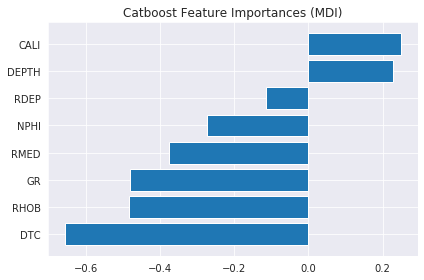

In [39]:
from catboost import Pool

train_pool = Pool(x_train, y_train)
tree_feature_importances = (best_class.get_feature_importance(train_pool, type='LossFunctionChange'))
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(X.columns))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(X.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Catboost Feature Importances (MDI)")
fig.tight_layout()
plt.show()


    * Confusion Matrix

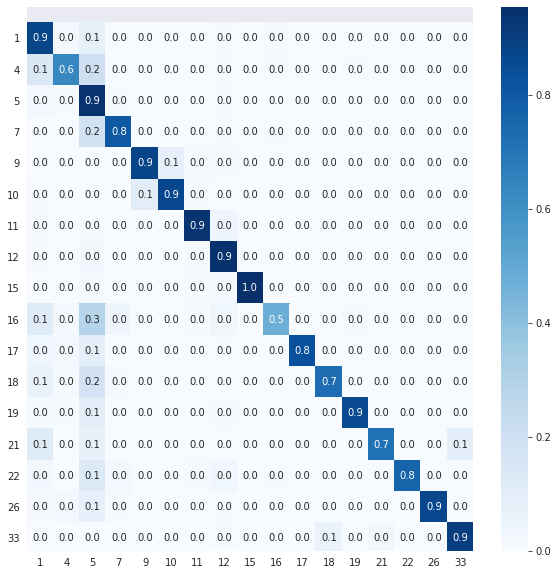

In [40]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], cmap=plt.cm.Blues, annot=True, fmt='.1f', xticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_2'].unique())
, yticklabels=np.sort(litho_data['LITHOLOGY_GEOLINK_2'].unique())
) # confusion matrix normalized as in Sklearn documentation

plt.yticks(rotation=0) 

ax.set_ylim(len(cf_matrix)-0.1, -0.5)

plt.show()

    * Null Values Prediction

        * Null Values Dataset 

null_litho_dataset = total_df[pd.isnull(total_df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME', 'LITHOLOGY_GEOLINK'])

        * Prediction

litho_prediction = best_rfc.predict(RobustScaler().fit_transform(null_litho_dataset))

        * Replacing Null Values for Predicted Ones

predicted_litho_dataset = null_litho_dataset

predicted_litho_dataset['LITHOLOGY_GEOLINK'] = litho_prediction

predicted_litho_dataset.head(n=5)

    * Final Dataframe

final_df = litho_data.append(predicted_litho_dataset)

final_df.sort_index(inplace=True)

final_df['WELL_NAME'] = total_df['WELL_NAME'].values

final_df.head(n=5)

# Checkpoints

path_file_final_df = '../checkpoints/final_df.csv.gz'

final_df.to_csv(path_file_final_df,index=False, compression='gzip')